In [29]:
import os
import torch
import torchaudio
import torchaudio.transforms as T



In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
     

In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
     

Mounted at /content/drive


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [33]:
!nvidia-smi


Mon Apr 24 23:32:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |  11099MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
# Read a single audio file, convert it to mono, and play

sample_audio= "/content/drive/MyDrive/DL project/0A4gEliYdWpZQeRt1en0XN_audio.mp3"
waveform, sample_rate = torchaudio.load(sample_audio)

# convert waveform to mono
waveform = torch.mean(waveform, dim = 0, keepdim=True)

type(waveform)

torch.Tensor

In [35]:
# from IPython.display import Audio, display

# display(Audio(sample_audio, autoplay=True))
# display(sample_audio)


In [36]:
# Plot waveform

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

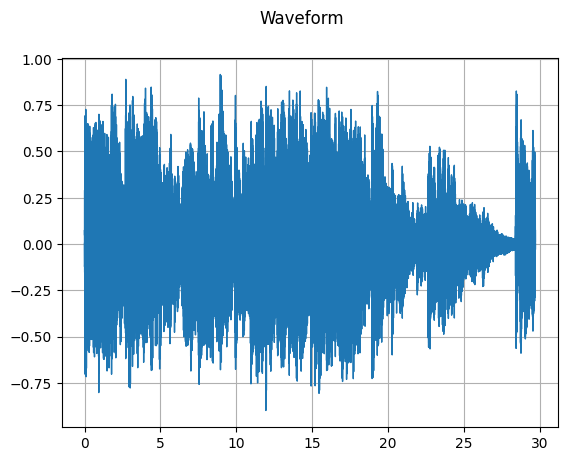

In [37]:
plot_waveform(waveform, sample_rate)

In [38]:
# generate spectrogram using torchaudio.transforms.Spectrogram()

import torchaudio.transforms as T

n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

type(spectrogram)

torchaudio.transforms._transforms.Spectrogram

In [39]:
spec = spectrogram(waveform)
#type(spec)
spec.shape

torch.Size([1, 513, 2560])

In [40]:
import librosa

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

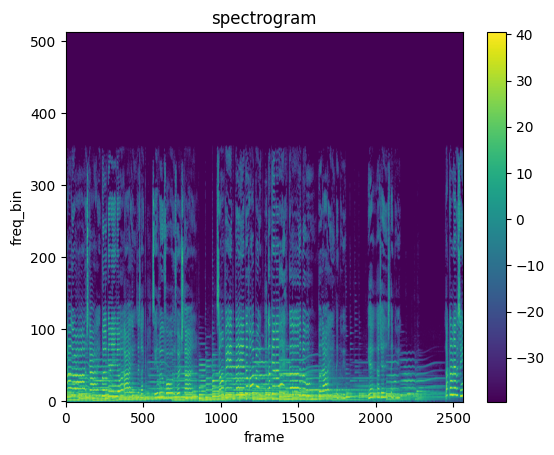

In [41]:
plot_spectrogram(spec[0], title="spectrogram")

In [42]:
# generate MFCC using torchaudio.transforms.MFCC()

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)


/usr/local/lib/python3.9/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


In [43]:
mfcc = mfcc_transform(waveform)

mfcc.shape

torch.Size([1, 256, 2560])

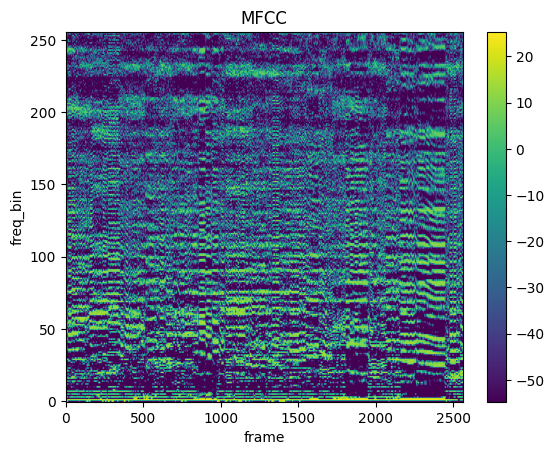

In [44]:
plot_spectrogram(mfcc[0], title="MFCC")

In [45]:
# dataloader: loads the entire data (csv and audio) and return mfcc and label
# it also does train test split based on "train" argument

# Note: I had to delete files with incorrect length: '4FAk7qcgJOMPm7qBoMncIj', '2VTHCLRoZNb499nctl9HeW', '4fIu2DeeeCfV6nxwgtbUVO'

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



# prepare/preprocess dataset 

class AudioDataset(Dataset):
    def __init__(self, audio_dir, csv_file, train=True, train_split=0.8):
        self.audio_dir = audio_dir
        self.csv_df = pd.read_csv(csv_file)
        self.csv_df = self.csv_df.drop_duplicates(keep="first")
        
        # check whether content of csv are files and add a dummy for is_file
        is_file = []
        brokenfiles = set(['4FAk7qcgJOMPm7qBoMncIj', '2VTHCLRoZNb499nctl9HeW', '4fIu2DeeeCfV6nxwgtbUVO'])
        for idx in range(len(self.csv_df)):
          id = self.csv_df.iloc[idx]['id']  # id column from the csv
          filename = f"{audio_dir}/{id}_audio.mp3"
          if os.path.isfile(filename) and (not id in brokenfiles):
            is_file.append(True)
          else:
            is_file.append(False)

        self.csv_df.insert(1, "is_file", is_file)
        self.csv_df = self.csv_df[self.csv_df["is_file"]]

        # shuffle rows in csv_df 
        self.csv_df = self.csv_df.sample(frac=1, random_state=10) 

        # if train return train_split% of data
        if train:
          self.csv_df = self.csv_df.iloc[:int(len(self.csv_df) * train_split)]

        # if not train return (1-train_split)% of data
        else:
          self.csv_df = self.csv_df.iloc[int(len(self.csv_df) * train_split):]

          
    def __len__(self):
        return len(self.csv_df)
    
    # read audio files one at a time and return the audio data, mfcc, and labels
    def __getitem__(self, idx):
        id = self.csv_df.iloc[idx]['id']  # id column from the csv
        filename = f"{self.audio_dir}/{id}_audio.mp3"
        waveform, sample_rate = torchaudio.load(filename)  # Load the actual data and the sample rate
        waveform = torch.mean(waveform, dim = 0, keepdim=True) # convert waveform to mono
        # waveform = waveform[:,:660000]
        label = torch.tensor(self.csv_df.iloc[idx][['danceability', 
                                                   'acousticness', 'energy', 'instrumentalness', 'speechiness']])  # Get the labels
        label = label.to(torch.float).to(device)
        
        mfcc = mfcc_transform(waveform)    
        mfcc = mfcc.to(torch.float).to(device)
                                                   
        return mfcc, label


In [46]:
audio_path = "/content/drive/MyDrive/DL project/tracks_features_audio"
csv_path = "/content/drive/MyDrive/DL project/tracks_features.csv"

dataset = AudioDataset(audio_path, csv_path)
dataloader = DataLoader(dataset, batch_size=1)

In [19]:
# # check whether audio lengths are identical 

# minlen = 1000000000
# maxlen = 0
# for batch_idx, (audio_data, labels) in enumerate(dataloader):
#     # Do something with the audio data and labels, such as passing them through a model
#     minlen = min(minlen, audio_data.shape[2])
#     maxlen = max(maxlen, audio_data.shape[2])
#     if audio_data.shape[2] != 1310328:
#       # print(f'id {labels.id}, Batch {batch_idx}: Audio data shape = {audio_data.shape}, labels shape = {labels.shape}')
#       print(labels)

# print(minlen, maxlen)


In [47]:
# CNN with pytorch using MFCC

import torch.nn as nn
import torch.nn.functional as F # contains useful functions such as activation functions, it is not a layer


class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.pooling = nn.AdaptiveAvgPool2d((8, 8)) # extended
        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.pooling(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x        

In [48]:
from torchsummary import summary

#print(mfccs.shape)

# model = CnnAudioNet(5)
# summary(model, (1, 256, 2560))

model = Net(5)
model.to(device)

summary(model, (1, 256, 2560))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 32, 254, 2558]             320
            Conv2d-2        [-1, 64, 252, 2556]          18,496
           Dropout-3        [-1, 64, 126, 1278]               0
            Conv2d-4       [-1, 128, 124, 1276]          73,856
            Conv2d-5       [-1, 256, 122, 1274]         295,168
           Dropout-6         [-1, 256, 61, 637]               0
 AdaptiveAvgPool2d-7            [-1, 256, 8, 8]               0
            Linear-8                  [-1, 128]       2,097,280
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 5]             645
Total params: 2,485,765
Trainable params: 2,485,765
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.50
Forward/backward pass size (MB): 1085.87
Params size (MB): 9.48
Esti

In [ ]:
# train the CNN model

audio_path = "/content/drive/MyDrive/DL project/tracks_features_audio"
csv_path = "/content/drive/MyDrive/DL project/tracks_features.csv"

dataset_train = AudioDataset(audio_path, csv_path, train=True, train_split=0.8)
dataloader = DataLoader(dataset_train, batch_size=16)


import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

model.train()


n_epochs = 6
epoch_loss = []
for epoch in range(1, n_epochs+1):
  batch_loss = []
  for batch_idx, (mfccs, labels) in enumerate(dataloader): 
    optimizer.zero_grad()
    outputs = model(mfccs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    #print(f"epoch: {epoch} batch_ind: {batch_idx} batch_loss: {float(loss)}")
    batch_loss.append(float(loss))
    
  epoch_loss.append(np.mean(batch_loss))

#print(f"epoch_losses: {epoch_loss}")


In [ ]:
# plt.title("Train Loss per Epoch")
# plt.xlabel("Epoch")
# plt.ylabel("Train Loss")
# plt.plot(epoch_loss)

In [ ]:
# # save model
# PATH = "/content/drive/MyDrive/DL project/cnn1"
# torch.save(model, PATH)

In [ ]:
# load model
PATH = "model_weights/cnn1"
model = torch.load(PATH, map_location=torch.device(device))


In [58]:
# evaluate the CNN model on test data

audio_path = "/content/drive/MyDrive/DL project/tracks_features_audio"
csv_path = "/content/drive/MyDrive/DL project/tracks_features.csv"

dataset_eval = AudioDataset(audio_path, csv_path, train=False, train_split=0.8)
dataloader = DataLoader(dataset_eval, batch_size=16)

mse = nn.MSELoss()
mae = nn.L1Loss()

model.eval()

batch_mse = []
batch_mae = []


with torch.no_grad():
  for batch_idx, (mfccs, labels) in enumerate(dataloader): 
    outputs = model(mfccs)
    mse_loss = mse(outputs, labels)
    mae_loss = mae(outputs, labels)
    #print(f"epoch: {epoch} batch_ind: {batch_idx} batch_loss: {float(loss)}")
    batch_mse.append(float(mse_loss))
    batch_mae.append(float(mae_loss))

print(f"MSE: {np.mean(batch_mse)}")
print(f"MAE: {np.mean(batch_mae)}")


# with torch.no_grad():
#   for batch_idx, (mfccs, labels) in enumerate(dataloader): 
#     print(batch_idx)
#     output = model(mfccs)
#     # if batch_idx == 0:
#     #   pred_label = output
#     #   true_label = labels
#     # else:
#     #   pred_label = torch.cat((pred_label, output))
#     #   true_label = torch.cat((true_label, labels))

#     mse_temp = nn.MSELoss(outputs, labels)
#     batch_mse.append(float(mse_temp))

#     mae_temp = nn.L1Loss(outputs, labels)
#     batch_mae.append(float(mae_temp))
        
# print(f"MSE: {np.mean(batch_mse)}, MAE: {np.mean(batch_mae)}")

# mse = nn.MSELoss(pred_label, true_label)
# mae = nn.L1Loss(pred_label, true_label)

# print(f"MSE: {mse}, MAE: {mae}")



MSE: 0.02617469404570081
MAE: 0.11103550717234612
